## Light DSFD: Light Dual Shot Face Detection

Dual Shot Face Detection seems to work well but is very slow and requires a large model. Can we get similar performance without paying such a high inference cost?

GitHub: https://github.com/lijiannuist/lightDSFD/

In [1]:
import cv2
import torch

from pathlib import Path
from lightDSFD.data import config, TestBaseTransform
from lightDSFD.light_face_ssd import build_ssd
from lightDSFD.test import infer
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
def read_frame_as_size(video_path, size=(128, 128)):
    capture = cv2.VideoCapture(str(video_path))
    ret, frame = capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, size)
    capture.release()
    return frame

def read_frame(video_path):
    capture = cv2.VideoCapture(str(video_path))
    ret, frame = capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    capture.release()
    return frame


def read_all_frames(video_path):
    capture = cv2.VideoCapture(str(video_path))
    all_frames = []
    ret = True
    while True:
        ret, frame = capture.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            all_frames.append(frame)
        else:
            break
    
    capture.release()
    return all_frames


def plot_detections(img, detections, with_keypoints=True):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.grid(False)
    ax.imshow(img)
    
    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    print("Found %d faces" % detections.shape[0])
        
    for i in range(detections.shape[0]):
        xmin = detections[i, 0]
        ymin = detections[i, 1]
        
        xmax = detections[i, 2]
        ymax = detections[i, 3]
        

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
        
    plt.show()

In [3]:
cfg = config.widerface_640
WIDERFace_CLASSES = ['face']  # We're only finding faces

In [4]:
num_classes = len(WIDERFace_CLASSES) + 1 # +1 background
net = build_ssd('test', cfg['min_dim'], num_classes) # initialize SSD

In [5]:
net.load_state_dict(torch.load('lightDSFD/weights/light_DSFD.pth'))

<All keys matched successfully>

In [6]:
net = net.cuda()
net = net.eval()

In [7]:
# evaluation
transform = TestBaseTransform((104, 117, 123))
thresh=cfg['conf_thresh']

In [8]:
data = Path('../data')

# Two easy faces to ensure that we can get facial recognition working
easy1 = data/'dfdc_train_part_2/abmjszfycr_REAL.mp4'
easy2 = data/'dfdc_train_part_11/aqyvunegbf_REAL.mp4'

In [9]:
frame1 = read_frame(easy1)
frame2 = read_frame(easy2)

In [10]:
detections1 = infer(net, frame1, transform, thresh, cuda=True, shrink=1)
detections2 = infer(net, frame2, transform, thresh, cuda=True, shrink=1)

Backbone: 0.1820 , FPN: 0.0020, CPM: 0.0068, Head: 0.0063, PA: 0.0001, Decode_NMS: 0.0442
Backbone: 0.0044 , FPN: 0.0006, CPM: 0.0054, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0178


/home/josh/anaconda3/envs/dl/lib/python3.7/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/josh/anaconda3/envs/dl/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)

Found 2 faces


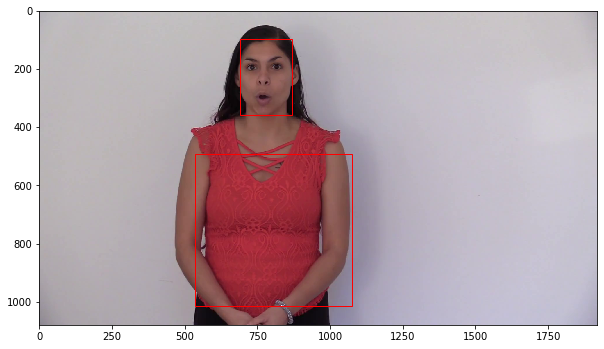

In [11]:
plot_detections(frame1, detections1)

Found 1 faces


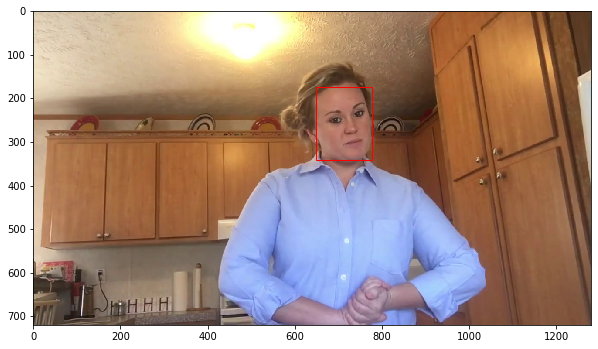

In [12]:
plot_detections(frame2, detections2)

## Get all faces in all frames

In [13]:
def show_faces(faces, rows, columns, figsize=(20, 20)):
    
    axes = plt.subplots(rows, columns, figsize=figsize)[1]
    
    for row in range(rows):
        rowOffset = row * columns
        
        for column in range(columns):
            if rowOffset + column < len(faces):
                face = faces[rowOffset + column]
                axes[row,column].imshow(face)

In [14]:
def get_cropped_faces(frame, detections):
    
    faces = []
    
    for detection in detections:
       
        xmin = max(0, int(detection[0])) # Don't try to crop less than 0
        ymin = max(0, int(detection[1])) # Don't try to crop less than 0
        xmax = min(frame.shape[1], int(detection[2]))
        ymax = min(frame.shape[0], int(detection[3]))
        
        face = frame[ymin:ymax, xmin:xmax]
        
        faces.append(face)
    
    return faces

In [15]:
def predict_all_frames(frames):
    
    predictions = []
    for frame in tqdm_notebook(frames):
        detections = infer(net, frame, transform, thresh, cuda=True, shrink=1)
        
        
        faces = get_cropped_faces(frame, detections)
        
        if len(faces) > 0:
            predictions.extend(faces)
            
    return predictions

In [16]:
all_frames1 = read_all_frames(easy1)
all_frames2 = read_all_frames(easy2)

In [17]:
all_faces1 = predict_all_frames(all_frames1)
all_faces2 = predict_all_frames(all_frames2)

/home/josh/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0054 , FPN: 0.0007, CPM: 0.0055, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0506
Backbone: 0.0044 , FPN: 0.0006, CPM: 0.0044, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0431
Backbone: 0.0043 , FPN: 0.0011, CPM: 0.0078, Head: 0.0058, PA: 0.0002, Decode_NMS: 0.0370


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0046 , FPN: 0.0006, CPM: 0.0065, Head: 0.0047, PA: 0.0001, Decode_NMS: 0.0415
Backbone: 0.0057 , FPN: 0.0008, CPM: 0.0055, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0512
Backbone: 0.0049 , FPN: 0.0007, CPM: 0.0052, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0505


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0050 , FPN: 0.0008, CPM: 0.0054, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0479
Backbone: 0.0047 , FPN: 0.0006, CPM: 0.0045, Head: 0.0032, PA: 0.0001, Decode_NMS: 0.0415
Backbone: 0.0052 , FPN: 0.0006, CPM: 0.0044, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0425


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0065 , FPN: 0.0011, CPM: 0.0052, Head: 0.0048, PA: 0.0001, Decode_NMS: 0.0397
Backbone: 0.0060 , FPN: 0.0008, CPM: 0.0061, Head: 0.0047, PA: 0.0002, Decode_NMS: 0.0506
Backbone: 0.0052 , FPN: 0.0007, CPM: 0.0055, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0501


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0051 , FPN: 0.0006, CPM: 0.0056, Head: 0.0037, PA: 0.0001, Decode_NMS: 0.0392
Backbone: 0.0054 , FPN: 0.0006, CPM: 0.0057, Head: 0.0044, PA: 0.0001, Decode_NMS: 0.0363
Backbone: 0.0045 , FPN: 0.0006, CPM: 0.0044, Head: 0.0035, PA: 0.0002, Decode_NMS: 0.0395


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0043 , FPN: 0.0006, CPM: 0.0052, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0469
Backbone: 0.0048 , FPN: 0.0010, CPM: 0.0067, Head: 0.0040, PA: 0.0003, Decode_NMS: 0.0387
Backbone: 0.0041 , FPN: 0.0006, CPM: 0.0051, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0434


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0059 , FPN: 0.0014, CPM: 0.0065, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0541
Backbone: 0.0054 , FPN: 0.0007, CPM: 0.0055, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0516


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0053 , FPN: 0.0007, CPM: 0.0054, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0518
Backbone: 0.0051 , FPN: 0.0007, CPM: 0.0057, Head: 0.0042, PA: 0.0002, Decode_NMS: 0.0499
Backbone: 0.0049 , FPN: 0.0007, CPM: 0.0052, Head: 0.0041, PA: 0.0001, Decode_NMS: 0.0403


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0054 , FPN: 0.0011, CPM: 0.0083, Head: 0.0045, PA: 0.0002, Decode_NMS: 0.0385
Backbone: 0.0045 , FPN: 0.0006, CPM: 0.0060, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0427
Backbone: 0.0050 , FPN: 0.0010, CPM: 0.0063, Head: 0.0036, PA: 0.0001, Decode_NMS: 0.0384


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0049 , FPN: 0.0007, CPM: 0.0058, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0483
Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0054, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0493
Backbone: 0.0051 , FPN: 0.0008, CPM: 0.0055, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0493


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0051 , FPN: 0.0007, CPM: 0.0053, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0491
Backbone: 0.0053 , FPN: 0.0008, CPM: 0.0054, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0506
Backbone: 0.0050 , FPN: 0.0007, CPM: 0.0053, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0497


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0051 , FPN: 0.0007, CPM: 0.0053, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0445
Backbone: 0.0055 , FPN: 0.0011, CPM: 0.0051, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0418
Backbone: 0.0053 , FPN: 0.0011, CPM: 0.0058, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0441


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0048 , FPN: 0.0006, CPM: 0.0047, Head: 0.0042, PA: 0.0001, Decode_NMS: 0.0478
Backbone: 0.0074 , FPN: 0.0009, CPM: 0.0070, Head: 0.0038, PA: 0.0002, Decode_NMS: 0.0534


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0053 , FPN: 0.0007, CPM: 0.0060, Head: 0.0057, PA: 0.0003, Decode_NMS: 0.0445
Backbone: 0.0055 , FPN: 0.0006, CPM: 0.0048, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0415
Backbone: 0.0054 , FPN: 0.0006, CPM: 0.0051, Head: 0.0033, PA: 0.0002, Decode_NMS: 0.0408


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0058 , FPN: 0.0008, CPM: 0.0053, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0487
Backbone: 0.0050 , FPN: 0.0007, CPM: 0.0056, Head: 0.0040, PA: 0.0003, Decode_NMS: 0.0506
Backbone: 0.0053 , FPN: 0.0006, CPM: 0.0045, Head: 0.0036, PA: 0.0001, Decode_NMS: 0.0408


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0054 , FPN: 0.0008, CPM: 0.0054, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0500
Backbone: 0.0053 , FPN: 0.0007, CPM: 0.0054, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0502
Backbone: 0.0052 , FPN: 0.0008, CPM: 0.0056, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0491


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0050 , FPN: 0.0008, CPM: 0.0054, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0479
Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0061, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0416
Backbone: 0.0048 , FPN: 0.0009, CPM: 0.0053, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0407


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0054 , FPN: 0.0011, CPM: 0.0060, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0419
Backbone: 0.0052 , FPN: 0.0006, CPM: 0.0049, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0413
Backbone: 0.0047 , FPN: 0.0006, CPM: 0.0047, Head: 0.0036, PA: 0.0001, Decode_NMS: 0.0407


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0055 , FPN: 0.0006, CPM: 0.0052, Head: 0.0044, PA: 0.0001, Decode_NMS: 0.0427
Backbone: 0.0053 , FPN: 0.0007, CPM: 0.0060, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0408
Backbone: 0.0042 , FPN: 0.0007, CPM: 0.0061, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0421


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0071 , FPN: 0.0011, CPM: 0.0052, Head: 0.0035, PA: 0.0002, Decode_NMS: 0.0402
Backbone: 0.0058 , FPN: 0.0006, CPM: 0.0047, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0430
Backbone: 0.0046 , FPN: 0.0006, CPM: 0.0050, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0399


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0075 , FPN: 0.0007, CPM: 0.0074, Head: 0.0058, PA: 0.0002, Decode_NMS: 0.0398
Backbone: 0.0055 , FPN: 0.0011, CPM: 0.0054, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0438
Backbone: 0.0047 , FPN: 0.0006, CPM: 0.0047, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0406


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0069 , FPN: 0.0006, CPM: 0.0046, Head: 0.0048, PA: 0.0002, Decode_NMS: 0.0398
Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0054, Head: 0.0044, PA: 0.0001, Decode_NMS: 0.0431
Backbone: 0.0064 , FPN: 0.0009, CPM: 0.0050, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0414


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0064 , FPN: 0.0006, CPM: 0.0048, Head: 0.0060, PA: 0.0002, Decode_NMS: 0.0401
Backbone: 0.0052 , FPN: 0.0006, CPM: 0.0067, Head: 0.0045, PA: 0.0002, Decode_NMS: 0.0410
Backbone: 0.0063 , FPN: 0.0008, CPM: 0.0060, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0410


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0072 , FPN: 0.0006, CPM: 0.0046, Head: 0.0040, PA: 0.0003, Decode_NMS: 0.0408
Backbone: 0.0047 , FPN: 0.0006, CPM: 0.0046, Head: 0.0055, PA: 0.0002, Decode_NMS: 0.0495
Backbone: 0.0047 , FPN: 0.0007, CPM: 0.0044, Head: 0.0032, PA: 0.0001, Decode_NMS: 0.0397


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0064 , FPN: 0.0006, CPM: 0.0046, Head: 0.0032, PA: 0.0001, Decode_NMS: 0.0409
Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0044, Head: 0.0032, PA: 0.0001, Decode_NMS: 0.0400
Backbone: 0.0048 , FPN: 0.0010, CPM: 0.0057, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0425


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0057 , FPN: 0.0010, CPM: 0.0061, Head: 0.0045, PA: 0.0002, Decode_NMS: 0.0408
Backbone: 0.0045 , FPN: 0.0007, CPM: 0.0045, Head: 0.0034, PA: 0.0002, Decode_NMS: 0.0392
Backbone: 0.0049 , FPN: 0.0007, CPM: 0.0058, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0501


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0043 , FPN: 0.0006, CPM: 0.0045, Head: 0.0036, PA: 0.0002, Decode_NMS: 0.0385
Backbone: 0.0049 , FPN: 0.0006, CPM: 0.0046, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0414
Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0044, Head: 0.0032, PA: 0.0001, Decode_NMS: 0.0390


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0052 , FPN: 0.0008, CPM: 0.0055, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0411
Backbone: 0.0051 , FPN: 0.0006, CPM: 0.0043, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0370
Backbone: 0.0047 , FPN: 0.0009, CPM: 0.0050, Head: 0.0032, PA: 0.0001, Decode_NMS: 0.0400


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0045 , FPN: 0.0006, CPM: 0.0064, Head: 0.0063, PA: 0.0002, Decode_NMS: 0.0525
Backbone: 0.0054 , FPN: 0.0008, CPM: 0.0056, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0417
Backbone: 0.0044 , FPN: 0.0006, CPM: 0.0048, Head: 0.0036, PA: 0.0001, Decode_NMS: 0.0407


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0068 , FPN: 0.0007, CPM: 0.0050, Head: 0.0037, PA: 0.0001, Decode_NMS: 0.0415
Backbone: 0.0043 , FPN: 0.0006, CPM: 0.0054, Head: 0.0032, PA: 0.0001, Decode_NMS: 0.0421
Backbone: 0.0047 , FPN: 0.0006, CPM: 0.0045, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0373


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0040 , FPN: 0.0006, CPM: 0.0056, Head: 0.0044, PA: 0.0002, Decode_NMS: 0.0439
Backbone: 0.0057 , FPN: 0.0006, CPM: 0.0044, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0405
Backbone: 0.0044 , FPN: 0.0008, CPM: 0.0045, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0405


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0052 , FPN: 0.0010, CPM: 0.0064, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0511
Backbone: 0.0054 , FPN: 0.0007, CPM: 0.0055, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0449
Backbone: 0.0046 , FPN: 0.0006, CPM: 0.0044, Head: 0.0032, PA: 0.0002, Decode_NMS: 0.0406


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0068 , FPN: 0.0009, CPM: 0.0046, Head: 0.0051, PA: 0.0002, Decode_NMS: 0.0370
Backbone: 0.0053 , FPN: 0.0011, CPM: 0.0080, Head: 0.0046, PA: 0.0001, Decode_NMS: 0.0374


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0043 , FPN: 0.0006, CPM: 0.0056, Head: 0.0038, PA: 0.0002, Decode_NMS: 0.0722
Backbone: 0.0053 , FPN: 0.0008, CPM: 0.0055, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0512
Backbone: 0.0055 , FPN: 0.0007, CPM: 0.0054, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0515


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0052 , FPN: 0.0007, CPM: 0.0054, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0499
Backbone: 0.0053 , FPN: 0.0008, CPM: 0.0055, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0462
Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0049, Head: 0.0038, PA: 0.0002, Decode_NMS: 0.0402


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0057 , FPN: 0.0009, CPM: 0.0070, Head: 0.0052, PA: 0.0002, Decode_NMS: 0.0444
Backbone: 0.0041 , FPN: 0.0007, CPM: 0.0046, Head: 0.0050, PA: 0.0002, Decode_NMS: 0.0439
Backbone: 0.0071 , FPN: 0.0010, CPM: 0.0077, Head: 0.0054, PA: 0.0002, Decode_NMS: 0.0421


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0058 , FPN: 0.0011, CPM: 0.0069, Head: 0.0049, PA: 0.0003, Decode_NMS: 0.0386
Backbone: 0.0047 , FPN: 0.0009, CPM: 0.0065, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0435
Backbone: 0.0051 , FPN: 0.0007, CPM: 0.0045, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0435


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0058 , FPN: 0.0011, CPM: 0.0083, Head: 0.0059, PA: 0.0001, Decode_NMS: 0.0423
Backbone: 0.0060 , FPN: 0.0010, CPM: 0.0065, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0449
Backbone: 0.0043 , FPN: 0.0007, CPM: 0.0050, Head: 0.0044, PA: 0.0001, Decode_NMS: 0.0431


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0056 , FPN: 0.0009, CPM: 0.0051, Head: 0.0034, PA: 0.0002, Decode_NMS: 0.0398
Backbone: 0.0053 , FPN: 0.0008, CPM: 0.0054, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0482
Backbone: 0.0049 , FPN: 0.0007, CPM: 0.0057, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0488


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0042 , FPN: 0.0007, CPM: 0.0047, Head: 0.0049, PA: 0.0001, Decode_NMS: 0.0393
Backbone: 0.0043 , FPN: 0.0006, CPM: 0.0045, Head: 0.0045, PA: 0.0002, Decode_NMS: 0.0408
Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0052, Head: 0.0044, PA: 0.0001, Decode_NMS: 0.0386


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0060 , FPN: 0.0012, CPM: 0.0081, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0384
Backbone: 0.0045 , FPN: 0.0006, CPM: 0.0051, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0414
Backbone: 0.0043 , FPN: 0.0008, CPM: 0.0060, Head: 0.0045, PA: 0.0002, Decode_NMS: 0.0369


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0041 , FPN: 0.0006, CPM: 0.0055, Head: 0.0054, PA: 0.0002, Decode_NMS: 0.0482
Backbone: 0.0051 , FPN: 0.0007, CPM: 0.0048, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0408
Backbone: 0.0058 , FPN: 0.0006, CPM: 0.0048, Head: 0.0032, PA: 0.0001, Decode_NMS: 0.0406


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0056 , FPN: 0.0008, CPM: 0.0054, Head: 0.0034, PA: 0.0002, Decode_NMS: 0.0413
Backbone: 0.0057 , FPN: 0.0007, CPM: 0.0062, Head: 0.0052, PA: 0.0002, Decode_NMS: 0.0407
Backbone: 0.0050 , FPN: 0.0007, CPM: 0.0056, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0483


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0043 , FPN: 0.0006, CPM: 0.0046, Head: 0.0042, PA: 0.0001, Decode_NMS: 0.0399
Backbone: 0.0041 , FPN: 0.0007, CPM: 0.0045, Head: 0.0034, PA: 0.0002, Decode_NMS: 0.0409
Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0047, Head: 0.0053, PA: 0.0002, Decode_NMS: 0.0381


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0061 , FPN: 0.0012, CPM: 0.0056, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0495
Backbone: 0.0049 , FPN: 0.0006, CPM: 0.0046, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0416
Backbone: 0.0053 , FPN: 0.0006, CPM: 0.0046, Head: 0.0049, PA: 0.0002, Decode_NMS: 0.0436


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0053 , FPN: 0.0007, CPM: 0.0056, Head: 0.0042, PA: 0.0002, Decode_NMS: 0.0505
Backbone: 0.0051 , FPN: 0.0007, CPM: 0.0052, Head: 0.0048, PA: 0.0002, Decode_NMS: 0.0492
Backbone: 0.0049 , FPN: 0.0007, CPM: 0.0055, Head: 0.0036, PA: 0.0002, Decode_NMS: 0.0419


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0050 , FPN: 0.0007, CPM: 0.0054, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0492
Backbone: 0.0053 , FPN: 0.0007, CPM: 0.0053, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0482
Backbone: 0.0050 , FPN: 0.0008, CPM: 0.0055, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0485


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0058, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0491
Backbone: 0.0049 , FPN: 0.0007, CPM: 0.0056, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0481
Backbone: 0.0043 , FPN: 0.0006, CPM: 0.0044, Head: 0.0032, PA: 0.0001, Decode_NMS: 0.0407


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0057 , FPN: 0.0006, CPM: 0.0048, Head: 0.0036, PA: 0.0001, Decode_NMS: 0.0404
Backbone: 0.0041 , FPN: 0.0006, CPM: 0.0046, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0412
Backbone: 0.0061 , FPN: 0.0010, CPM: 0.0079, Head: 0.0044, PA: 0.0001, Decode_NMS: 0.0398


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0055 , FPN: 0.0007, CPM: 0.0068, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0429
Backbone: 0.0060 , FPN: 0.0006, CPM: 0.0048, Head: 0.0045, PA: 0.0003, Decode_NMS: 0.0383
Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0055, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0500


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0054 , FPN: 0.0008, CPM: 0.0054, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0471
Backbone: 0.0044 , FPN: 0.0006, CPM: 0.0064, Head: 0.0032, PA: 0.0001, Decode_NMS: 0.0414
Backbone: 0.0050 , FPN: 0.0007, CPM: 0.0054, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0491


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0054 , FPN: 0.0006, CPM: 0.0059, Head: 0.0049, PA: 0.0002, Decode_NMS: 0.0398
Backbone: 0.0042 , FPN: 0.0008, CPM: 0.0059, Head: 0.0047, PA: 0.0002, Decode_NMS: 0.0409
Backbone: 0.0056 , FPN: 0.0009, CPM: 0.0055, Head: 0.0032, PA: 0.0001, Decode_NMS: 0.0394


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0074 , FPN: 0.0008, CPM: 0.0048, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0470
Backbone: 0.0041 , FPN: 0.0006, CPM: 0.0063, Head: 0.0048, PA: 0.0003, Decode_NMS: 0.0442
Backbone: 0.0045 , FPN: 0.0006, CPM: 0.0045, Head: 0.0036, PA: 0.0002, Decode_NMS: 0.0427


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0051 , FPN: 0.0007, CPM: 0.0057, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0494
Backbone: 0.0059 , FPN: 0.0010, CPM: 0.0078, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0392
Backbone: 0.0062 , FPN: 0.0006, CPM: 0.0045, Head: 0.0032, PA: 0.0001, Decode_NMS: 0.0430


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0051 , FPN: 0.0008, CPM: 0.0058, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0486
Backbone: 0.0049 , FPN: 0.0007, CPM: 0.0056, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0480
Backbone: 0.0046 , FPN: 0.0006, CPM: 0.0047, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0400


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0043 , FPN: 0.0006, CPM: 0.0047, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0425
Backbone: 0.0058 , FPN: 0.0012, CPM: 0.0062, Head: 0.0036, PA: 0.0001, Decode_NMS: 0.0488
Backbone: 0.0062 , FPN: 0.0008, CPM: 0.0050, Head: 0.0035, PA: 0.0002, Decode_NMS: 0.0445


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0045 , FPN: 0.0010, CPM: 0.0066, Head: 0.0046, PA: 0.0003, Decode_NMS: 0.0407
Backbone: 0.0063 , FPN: 0.0008, CPM: 0.0065, Head: 0.0047, PA: 0.0002, Decode_NMS: 0.0533


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0058 , FPN: 0.0009, CPM: 0.0070, Head: 0.0048, PA: 0.0002, Decode_NMS: 0.0468
Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0062, Head: 0.0034, PA: 0.0002, Decode_NMS: 0.0443
Backbone: 0.0045 , FPN: 0.0007, CPM: 0.0048, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0519


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0052 , FPN: 0.0007, CPM: 0.0047, Head: 0.0050, PA: 0.0003, Decode_NMS: 0.0466
Backbone: 0.0046 , FPN: 0.0006, CPM: 0.0044, Head: 0.0051, PA: 0.0002, Decode_NMS: 0.0384
Backbone: 0.0043 , FPN: 0.0009, CPM: 0.0080, Head: 0.0058, PA: 0.0002, Decode_NMS: 0.0389


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0043 , FPN: 0.0006, CPM: 0.0063, Head: 0.0037, PA: 0.0002, Decode_NMS: 0.0448
Backbone: 0.0066 , FPN: 0.0006, CPM: 0.0045, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0409
Backbone: 0.0053 , FPN: 0.0006, CPM: 0.0048, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0400


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0054 , FPN: 0.0006, CPM: 0.0045, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0391
Backbone: 0.0045 , FPN: 0.0006, CPM: 0.0044, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0394
Backbone: 0.0041 , FPN: 0.0007, CPM: 0.0044, Head: 0.0038, PA: 0.0002, Decode_NMS: 0.0400


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0046 , FPN: 0.0011, CPM: 0.0047, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0428
Backbone: 0.0041 , FPN: 0.0006, CPM: 0.0047, Head: 0.0050, PA: 0.0002, Decode_NMS: 0.0399
Backbone: 0.0072 , FPN: 0.0010, CPM: 0.0056, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0406


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0056 , FPN: 0.0007, CPM: 0.0058, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0492
Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0049, Head: 0.0041, PA: 0.0001, Decode_NMS: 0.0386
Backbone: 0.0069 , FPN: 0.0009, CPM: 0.0047, Head: 0.0038, PA: 0.0002, Decode_NMS: 0.0384


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0043 , FPN: 0.0008, CPM: 0.0049, Head: 0.0043, PA: 0.0001, Decode_NMS: 0.0390
Backbone: 0.0053 , FPN: 0.0006, CPM: 0.0045, Head: 0.0048, PA: 0.0002, Decode_NMS: 0.0412
Backbone: 0.0041 , FPN: 0.0007, CPM: 0.0067, Head: 0.0050, PA: 0.0002, Decode_NMS: 0.0438


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0055 , FPN: 0.0007, CPM: 0.0045, Head: 0.0032, PA: 0.0001, Decode_NMS: 0.0397
Backbone: 0.0053 , FPN: 0.0008, CPM: 0.0061, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0507
Backbone: 0.0054 , FPN: 0.0008, CPM: 0.0056, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0491


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0053 , FPN: 0.0009, CPM: 0.0055, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0506
Backbone: 0.0053 , FPN: 0.0007, CPM: 0.0060, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0496
Backbone: 0.0048 , FPN: 0.0010, CPM: 0.0059, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0507


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0050 , FPN: 0.0008, CPM: 0.0059, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0492
Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0059, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0494
Backbone: 0.0043 , FPN: 0.0006, CPM: 0.0045, Head: 0.0046, PA: 0.0007, Decode_NMS: 0.0463


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0046 , FPN: 0.0006, CPM: 0.0049, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0411
Backbone: 0.0048 , FPN: 0.0006, CPM: 0.0049, Head: 0.0037, PA: 0.0001, Decode_NMS: 0.0402
Backbone: 0.0046 , FPN: 0.0009, CPM: 0.0074, Head: 0.0035, PA: 0.0002, Decode_NMS: 0.0420


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0067 , FPN: 0.0011, CPM: 0.0055, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0391
Backbone: 0.0057 , FPN: 0.0008, CPM: 0.0047, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0432
Backbone: 0.0047 , FPN: 0.0007, CPM: 0.0050, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0421


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0054 , FPN: 0.0006, CPM: 0.0049, Head: 0.0042, PA: 0.0002, Decode_NMS: 0.0436
Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0069, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0424
Backbone: 0.0051 , FPN: 0.0008, CPM: 0.0048, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0407


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0072 , FPN: 0.0007, CPM: 0.0056, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0495
Backbone: 0.0046 , FPN: 0.0007, CPM: 0.0053, Head: 0.0059, PA: 0.0002, Decode_NMS: 0.0435
Backbone: 0.0044 , FPN: 0.0006, CPM: 0.0051, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0416


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0055 , FPN: 0.0006, CPM: 0.0048, Head: 0.0045, PA: 0.0002, Decode_NMS: 0.0383
Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0057, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0458
Backbone: 0.0061 , FPN: 0.0007, CPM: 0.0050, Head: 0.0039, PA: 0.0003, Decode_NMS: 0.0468


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0053 , FPN: 0.0008, CPM: 0.0070, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0423
Backbone: 0.0066 , FPN: 0.0009, CPM: 0.0068, Head: 0.0055, PA: 0.0002, Decode_NMS: 0.0474
Backbone: 0.0051 , FPN: 0.0010, CPM: 0.0050, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0407


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0060 , FPN: 0.0008, CPM: 0.0051, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0391
Backbone: 0.0047 , FPN: 0.0006, CPM: 0.0047, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0417
Backbone: 0.0048 , FPN: 0.0010, CPM: 0.0057, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0451


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0057 , FPN: 0.0006, CPM: 0.0045, Head: 0.0035, PA: 0.0002, Decode_NMS: 0.0430
Backbone: 0.0043 , FPN: 0.0006, CPM: 0.0052, Head: 0.0041, PA: 0.0001, Decode_NMS: 0.0426
Backbone: 0.0042 , FPN: 0.0007, CPM: 0.0058, Head: 0.0037, PA: 0.0002, Decode_NMS: 0.0449


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0054 , FPN: 0.0008, CPM: 0.0056, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0511
Backbone: 0.0049 , FPN: 0.0007, CPM: 0.0050, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0413


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0063 , FPN: 0.0009, CPM: 0.0074, Head: 0.0052, PA: 0.0002, Decode_NMS: 0.0647
Backbone: 0.0042 , FPN: 0.0009, CPM: 0.0050, Head: 0.0044, PA: 0.0002, Decode_NMS: 0.0438
Backbone: 0.0055 , FPN: 0.0009, CPM: 0.0049, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0431


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0064 , FPN: 0.0009, CPM: 0.0048, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0453
Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0062, Head: 0.0037, PA: 0.0001, Decode_NMS: 0.0424
Backbone: 0.0046 , FPN: 0.0009, CPM: 0.0060, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0407


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0059 , FPN: 0.0010, CPM: 0.0074, Head: 0.0049, PA: 0.0003, Decode_NMS: 0.0412
Backbone: 0.0046 , FPN: 0.0007, CPM: 0.0047, Head: 0.0048, PA: 0.0002, Decode_NMS: 0.0411
Backbone: 0.0045 , FPN: 0.0006, CPM: 0.0066, Head: 0.0037, PA: 0.0001, Decode_NMS: 0.0386


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0067 , FPN: 0.0010, CPM: 0.0071, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0446
Backbone: 0.0046 , FPN: 0.0006, CPM: 0.0049, Head: 0.0045, PA: 0.0002, Decode_NMS: 0.0391
Backbone: 0.0057 , FPN: 0.0006, CPM: 0.0049, Head: 0.0037, PA: 0.0001, Decode_NMS: 0.0398


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0049 , FPN: 0.0007, CPM: 0.0064, Head: 0.0053, PA: 0.0002, Decode_NMS: 0.0542
Backbone: 0.0047 , FPN: 0.0006, CPM: 0.0055, Head: 0.0042, PA: 0.0001, Decode_NMS: 0.0435
Backbone: 0.0050 , FPN: 0.0007, CPM: 0.0049, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0393


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0071 , FPN: 0.0011, CPM: 0.0065, Head: 0.0036, PA: 0.0002, Decode_NMS: 0.0433
Backbone: 0.0044 , FPN: 0.0007, CPM: 0.0049, Head: 0.0041, PA: 0.0001, Decode_NMS: 0.0431
Backbone: 0.0072 , FPN: 0.0007, CPM: 0.0066, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0393


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0059, Head: 0.0038, PA: 0.0002, Decode_NMS: 0.0427
Backbone: 0.0051 , FPN: 0.0006, CPM: 0.0047, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0427
Backbone: 0.0055 , FPN: 0.0006, CPM: 0.0047, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0451


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0066 , FPN: 0.0009, CPM: 0.0078, Head: 0.0045, PA: 0.0002, Decode_NMS: 0.0409
Backbone: 0.0050 , FPN: 0.0006, CPM: 0.0047, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0414
Backbone: 0.0057 , FPN: 0.0006, CPM: 0.0047, Head: 0.0036, PA: 0.0002, Decode_NMS: 0.0429


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0055 , FPN: 0.0006, CPM: 0.0055, Head: 0.0048, PA: 0.0001, Decode_NMS: 0.0416
Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0060, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0415
Backbone: 0.0044 , FPN: 0.0006, CPM: 0.0058, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0407


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0047 , FPN: 0.0006, CPM: 0.0062, Head: 0.0042, PA: 0.0002, Decode_NMS: 0.0486
Backbone: 0.0049 , FPN: 0.0007, CPM: 0.0053, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0487
Backbone: 0.0044 , FPN: 0.0010, CPM: 0.0055, Head: 0.0055, PA: 0.0002, Decode_NMS: 0.0426


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0045, Head: 0.0037, PA: 0.0002, Decode_NMS: 0.0409
Backbone: 0.0044 , FPN: 0.0008, CPM: 0.0046, Head: 0.0035, PA: 0.0002, Decode_NMS: 0.0426
Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0050, Head: 0.0044, PA: 0.0001, Decode_NMS: 0.0418


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0053 , FPN: 0.0008, CPM: 0.0061, Head: 0.0044, PA: 0.0002, Decode_NMS: 0.0497
Backbone: 0.0049 , FPN: 0.0007, CPM: 0.0055, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0499
Backbone: 0.0051 , FPN: 0.0007, CPM: 0.0053, Head: 0.0041, PA: 0.0003, Decode_NMS: 0.0488


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0050 , FPN: 0.0008, CPM: 0.0054, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0487
Backbone: 0.0049 , FPN: 0.0006, CPM: 0.0062, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0436
Backbone: 0.0060 , FPN: 0.0006, CPM: 0.0051, Head: 0.0038, PA: 0.0002, Decode_NMS: 0.0411


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0049 , FPN: 0.0006, CPM: 0.0046, Head: 0.0052, PA: 0.0002, Decode_NMS: 0.0406
Backbone: 0.0049 , FPN: 0.0007, CPM: 0.0058, Head: 0.0041, PA: 0.0001, Decode_NMS: 0.0482
Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0054, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0494


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0049 , FPN: 0.0007, CPM: 0.0054, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0474
Backbone: 0.0053 , FPN: 0.0008, CPM: 0.0057, Head: 0.0045, PA: 0.0002, Decode_NMS: 0.0489
Backbone: 0.0047 , FPN: 0.0006, CPM: 0.0046, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0403


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0060 , FPN: 0.0011, CPM: 0.0086, Head: 0.0048, PA: 0.0001, Decode_NMS: 0.0382
Backbone: 0.0048 , FPN: 0.0010, CPM: 0.0068, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0434
Backbone: 0.0055 , FPN: 0.0006, CPM: 0.0046, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0412


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0053 , FPN: 0.0007, CPM: 0.0054, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0502
Backbone: 0.0052 , FPN: 0.0006, CPM: 0.0047, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0430
Backbone: 0.0045 , FPN: 0.0006, CPM: 0.0049, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0423


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0058 , FPN: 0.0011, CPM: 0.0085, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0382
Backbone: 0.0051 , FPN: 0.0007, CPM: 0.0054, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0429
Backbone: 0.0044 , FPN: 0.0006, CPM: 0.0047, Head: 0.0042, PA: 0.0002, Decode_NMS: 0.0399


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0050 , FPN: 0.0007, CPM: 0.0054, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0492
Backbone: 0.0051 , FPN: 0.0007, CPM: 0.0053, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0481
Backbone: 0.0049 , FPN: 0.0008, CPM: 0.0056, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0482


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0056, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0487
Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0054, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0475
Backbone: 0.0057 , FPN: 0.0007, CPM: 0.0051, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0401


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0059 , FPN: 0.0006, CPM: 0.0049, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0432
Backbone: 0.0043 , FPN: 0.0006, CPM: 0.0052, Head: 0.0044, PA: 0.0002, Decode_NMS: 0.0431
Backbone: 0.0060 , FPN: 0.0011, CPM: 0.0053, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0417


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0058 , FPN: 0.0010, CPM: 0.0080, Head: 0.0050, PA: 0.0001, Decode_NMS: 0.0391
Backbone: 0.0050 , FPN: 0.0007, CPM: 0.0057, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0486
Backbone: 0.0052 , FPN: 0.0007, CPM: 0.0053, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0482


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0050 , FPN: 0.0006, CPM: 0.0044, Head: 0.0036, PA: 0.0002, Decode_NMS: 0.0389
Backbone: 0.0058 , FPN: 0.0006, CPM: 0.0061, Head: 0.0051, PA: 0.0002, Decode_NMS: 0.0399
Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0045, Head: 0.0038, PA: 0.0002, Decode_NMS: 0.0419


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0060 , FPN: 0.0007, CPM: 0.0049, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0400
Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0054, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0495
Backbone: 0.0044 , FPN: 0.0006, CPM: 0.0045, Head: 0.0036, PA: 0.0002, Decode_NMS: 0.0400


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0059 , FPN: 0.0006, CPM: 0.0051, Head: 0.0047, PA: 0.0002, Decode_NMS: 0.0409
Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0052, Head: 0.0046, PA: 0.0001, Decode_NMS: 0.0419
Backbone: 0.0047 , FPN: 0.0008, CPM: 0.0053, Head: 0.0053, PA: 0.0002, Decode_NMS: 0.0426
Backbone: 0.0050 , FPN: 0.0006, CPM: 0.0065, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0400
Backbone: 0.0042 , FPN: 0.0007, CPM: 0.0047, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0399



/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0058 , FPN: 0.0007, CPM: 0.0058, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0230


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0054 , FPN: 0.0008, CPM: 0.0056, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0191
Backbone: 0.0057 , FPN: 0.0007, CPM: 0.0054, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0231
Backbone: 0.0050 , FPN: 0.0007, CPM: 0.0055, Head: 0.0041, PA: 0.0001, Decode_NMS: 0.0214
Backbone: 0.0050 , FPN: 0.0006, CPM: 0.0045, Head: 0.0032, PA: 0.0001, Decode_NMS: 0.0186


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0057, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0174


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0044 , FPN: 0.0010, CPM: 0.0054, Head: 0.0046, PA: 0.0001, Decode_NMS: 0.0180
Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0046, Head: 0.0038, PA: 0.0002, Decode_NMS: 0.0189
Backbone: 0.0049 , FPN: 0.0010, CPM: 0.0051, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0170
Backbone: 0.0044 , FPN: 0.0007, CPM: 0.0052, Head: 0.0041, PA: 0.0001, Decode_NMS: 0.0182


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0044 , FPN: 0.0006, CPM: 0.0058, Head: 0.0050, PA: 0.0002, Decode_NMS: 0.0196


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0058 , FPN: 0.0006, CPM: 0.0059, Head: 0.0045, PA: 0.0001, Decode_NMS: 0.0221
Backbone: 0.0052 , FPN: 0.0006, CPM: 0.0051, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0178
Backbone: 0.0043 , FPN: 0.0010, CPM: 0.0068, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0185
Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0054, Head: 0.0050, PA: 0.0001, Decode_NMS: 0.0173


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0050 , FPN: 0.0010, CPM: 0.0069, Head: 0.0046, PA: 0.0002, Decode_NMS: 0.0182


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0062 , FPN: 0.0011, CPM: 0.0060, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0229
Backbone: 0.0050 , FPN: 0.0008, CPM: 0.0053, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0225
Backbone: 0.0054 , FPN: 0.0008, CPM: 0.0055, Head: 0.0042, PA: 0.0002, Decode_NMS: 0.0221


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0054, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0229


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0056 , FPN: 0.0008, CPM: 0.0059, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0232
Backbone: 0.0048 , FPN: 0.0008, CPM: 0.0060, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0215
Backbone: 0.0051 , FPN: 0.0008, CPM: 0.0056, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0232


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0052 , FPN: 0.0008, CPM: 0.0052, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0183
Backbone: 0.0051 , FPN: 0.0010, CPM: 0.0047, Head: 0.0032, PA: 0.0001, Decode_NMS: 0.0203


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0048 , FPN: 0.0008, CPM: 0.0060, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0220
Backbone: 0.0054 , FPN: 0.0007, CPM: 0.0047, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0191
Backbone: 0.0041 , FPN: 0.0007, CPM: 0.0046, Head: 0.0041, PA: 0.0001, Decode_NMS: 0.0177


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0068 , FPN: 0.0007, CPM: 0.0046, Head: 0.0046, PA: 0.0002, Decode_NMS: 0.0198
Backbone: 0.0050 , FPN: 0.0006, CPM: 0.0045, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0186


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0041 , FPN: 0.0006, CPM: 0.0061, Head: 0.0036, PA: 0.0002, Decode_NMS: 0.0204
Backbone: 0.0058 , FPN: 0.0006, CPM: 0.0050, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0171
Backbone: 0.0050 , FPN: 0.0007, CPM: 0.0054, Head: 0.0044, PA: 0.0002, Decode_NMS: 0.0187


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0050 , FPN: 0.0010, CPM: 0.0058, Head: 0.0051, PA: 0.0002, Decode_NMS: 0.0194
Backbone: 0.0056 , FPN: 0.0006, CPM: 0.0044, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0204


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0058 , FPN: 0.0010, CPM: 0.0057, Head: 0.0036, PA: 0.0002, Decode_NMS: 0.0179
Backbone: 0.0061 , FPN: 0.0006, CPM: 0.0053, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0205
Backbone: 0.0041 , FPN: 0.0006, CPM: 0.0053, Head: 0.0042, PA: 0.0001, Decode_NMS: 0.0180


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0069 , FPN: 0.0006, CPM: 0.0046, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0167
Backbone: 0.0053 , FPN: 0.0008, CPM: 0.0055, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0230


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0056 , FPN: 0.0008, CPM: 0.0063, Head: 0.0041, PA: 0.0001, Decode_NMS: 0.0223
Backbone: 0.0055 , FPN: 0.0006, CPM: 0.0045, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0192
Backbone: 0.0042 , FPN: 0.0010, CPM: 0.0060, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0173


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0045 , FPN: 0.0006, CPM: 0.0059, Head: 0.0050, PA: 0.0001, Decode_NMS: 0.0174
Backbone: 0.0046 , FPN: 0.0006, CPM: 0.0046, Head: 0.0032, PA: 0.0001, Decode_NMS: 0.0191


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0042 , FPN: 0.0010, CPM: 0.0056, Head: 0.0048, PA: 0.0002, Decode_NMS: 0.0216
Backbone: 0.0057 , FPN: 0.0007, CPM: 0.0053, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0237
Backbone: 0.0052 , FPN: 0.0007, CPM: 0.0057, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0223


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0052 , FPN: 0.0006, CPM: 0.0045, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0220


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0055 , FPN: 0.0006, CPM: 0.0062, Head: 0.0036, PA: 0.0001, Decode_NMS: 0.0174
Backbone: 0.0068 , FPN: 0.0010, CPM: 0.0057, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0192
Backbone: 0.0041 , FPN: 0.0009, CPM: 0.0061, Head: 0.0045, PA: 0.0002, Decode_NMS: 0.0170
Backbone: 0.0045 , FPN: 0.0006, CPM: 0.0059, Head: 0.0042, PA: 0.0001, Decode_NMS: 0.0169


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0057 , FPN: 0.0006, CPM: 0.0044, Head: 0.0037, PA: 0.0001, Decode_NMS: 0.0192


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0046 , FPN: 0.0014, CPM: 0.0060, Head: 0.0044, PA: 0.0001, Decode_NMS: 0.0185
Backbone: 0.0062 , FPN: 0.0007, CPM: 0.0047, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0195
Backbone: 0.0041 , FPN: 0.0007, CPM: 0.0057, Head: 0.0034, PA: 0.0002, Decode_NMS: 0.0178
Backbone: 0.0051 , FPN: 0.0006, CPM: 0.0055, Head: 0.0042, PA: 0.0001, Decode_NMS: 0.0176


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0057 , FPN: 0.0007, CPM: 0.0055, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0231


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0052 , FPN: 0.0007, CPM: 0.0054, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0233
Backbone: 0.0049 , FPN: 0.0007, CPM: 0.0055, Head: 0.0048, PA: 0.0001, Decode_NMS: 0.0183
Backbone: 0.0054 , FPN: 0.0007, CPM: 0.0058, Head: 0.0050, PA: 0.0002, Decode_NMS: 0.0184
Backbone: 0.0054 , FPN: 0.0006, CPM: 0.0045, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0194


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0045 , FPN: 0.0008, CPM: 0.0069, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0179


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0062 , FPN: 0.0007, CPM: 0.0062, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0216
Backbone: 0.0041 , FPN: 0.0006, CPM: 0.0048, Head: 0.0049, PA: 0.0001, Decode_NMS: 0.0175
Backbone: 0.0055 , FPN: 0.0007, CPM: 0.0060, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0187
Backbone: 0.0053 , FPN: 0.0007, CPM: 0.0054, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0221


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0067 , FPN: 0.0009, CPM: 0.0059, Head: 0.0042, PA: 0.0002, Decode_NMS: 0.0169


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0054 , FPN: 0.0006, CPM: 0.0045, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0195
Backbone: 0.0042 , FPN: 0.0008, CPM: 0.0061, Head: 0.0037, PA: 0.0001, Decode_NMS: 0.0180
Backbone: 0.0043 , FPN: 0.0006, CPM: 0.0048, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0184
Backbone: 0.0051 , FPN: 0.0006, CPM: 0.0045, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0190


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0063 , FPN: 0.0008, CPM: 0.0061, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0232


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0072 , FPN: 0.0007, CPM: 0.0055, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0225
Backbone: 0.0050 , FPN: 0.0006, CPM: 0.0057, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0183
Backbone: 0.0048 , FPN: 0.0006, CPM: 0.0050, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0183
Backbone: 0.0041 , FPN: 0.0006, CPM: 0.0068, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0190


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0060 , FPN: 0.0008, CPM: 0.0059, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0249


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0050 , FPN: 0.0009, CPM: 0.0059, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0221
Backbone: 0.0051 , FPN: 0.0006, CPM: 0.0050, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0206
Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0047, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0179
Backbone: 0.0056 , FPN: 0.0006, CPM: 0.0046, Head: 0.0034, PA: 0.0002, Decode_NMS: 0.0187


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0062 , FPN: 0.0007, CPM: 0.0057, Head: 0.0041, PA: 0.0001, Decode_NMS: 0.0233


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0075 , FPN: 0.0007, CPM: 0.0057, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0223
Backbone: 0.0052 , FPN: 0.0007, CPM: 0.0053, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0220
Backbone: 0.0050 , FPN: 0.0009, CPM: 0.0060, Head: 0.0041, PA: 0.0001, Decode_NMS: 0.0255


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0048 , FPN: 0.0008, CPM: 0.0055, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0223


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0061 , FPN: 0.0009, CPM: 0.0056, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0199
Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0064, Head: 0.0047, PA: 0.0001, Decode_NMS: 0.0185
Backbone: 0.0054 , FPN: 0.0008, CPM: 0.0047, Head: 0.0043, PA: 0.0001, Decode_NMS: 0.0170
Backbone: 0.0050 , FPN: 0.0006, CPM: 0.0045, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0176


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0047 , FPN: 0.0008, CPM: 0.0060, Head: 0.0047, PA: 0.0002, Decode_NMS: 0.0228


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0064 , FPN: 0.0007, CPM: 0.0055, Head: 0.0042, PA: 0.0001, Decode_NMS: 0.0229
Backbone: 0.0053 , FPN: 0.0007, CPM: 0.0058, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0222
Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0055, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0222


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0050, Head: 0.0048, PA: 0.0001, Decode_NMS: 0.0184


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0057 , FPN: 0.0007, CPM: 0.0059, Head: 0.0044, PA: 0.0002, Decode_NMS: 0.0232
Backbone: 0.0053 , FPN: 0.0017, CPM: 0.0059, Head: 0.0041, PA: 0.0003, Decode_NMS: 0.0244
Backbone: 0.0057 , FPN: 0.0007, CPM: 0.0058, Head: 0.0046, PA: 0.0002, Decode_NMS: 0.0240


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0047 , FPN: 0.0006, CPM: 0.0045, Head: 0.0046, PA: 0.0002, Decode_NMS: 0.0192


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0064 , FPN: 0.0009, CPM: 0.0071, Head: 0.0052, PA: 0.0001, Decode_NMS: 0.0196
Backbone: 0.0053 , FPN: 0.0006, CPM: 0.0065, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0193
Backbone: 0.0059 , FPN: 0.0008, CPM: 0.0056, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0166
Backbone: 0.0047 , FPN: 0.0006, CPM: 0.0044, Head: 0.0032, PA: 0.0001, Decode_NMS: 0.0198


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0059 , FPN: 0.0011, CPM: 0.0062, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0171


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0060 , FPN: 0.0008, CPM: 0.0049, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0195
Backbone: 0.0041 , FPN: 0.0006, CPM: 0.0058, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0179
Backbone: 0.0055 , FPN: 0.0008, CPM: 0.0057, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0254
Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0055, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0222


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0054 , FPN: 0.0008, CPM: 0.0059, Head: 0.0042, PA: 0.0001, Decode_NMS: 0.0232


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0043 , FPN: 0.0010, CPM: 0.0074, Head: 0.0044, PA: 0.0002, Decode_NMS: 0.0170
Backbone: 0.0050 , FPN: 0.0006, CPM: 0.0053, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0177
Backbone: 0.0040 , FPN: 0.0009, CPM: 0.0049, Head: 0.0037, PA: 0.0001, Decode_NMS: 0.0184
Backbone: 0.0063 , FPN: 0.0006, CPM: 0.0055, Head: 0.0036, PA: 0.0001, Decode_NMS: 0.0168


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0049 , FPN: 0.0008, CPM: 0.0056, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0213


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0051 , FPN: 0.0007, CPM: 0.0066, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0225
Backbone: 0.0057 , FPN: 0.0007, CPM: 0.0053, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0234
Backbone: 0.0055 , FPN: 0.0007, CPM: 0.0058, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0168
Backbone: 0.0059 , FPN: 0.0008, CPM: 0.0045, Head: 0.0032, PA: 0.0001, Decode_NMS: 0.0195


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0042 , FPN: 0.0010, CPM: 0.0059, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0171


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0048 , FPN: 0.0010, CPM: 0.0054, Head: 0.0043, PA: 0.0001, Decode_NMS: 0.0181
Backbone: 0.0044 , FPN: 0.0006, CPM: 0.0045, Head: 0.0037, PA: 0.0002, Decode_NMS: 0.0197
Backbone: 0.0056 , FPN: 0.0010, CPM: 0.0050, Head: 0.0036, PA: 0.0001, Decode_NMS: 0.0191
Backbone: 0.0054 , FPN: 0.0007, CPM: 0.0055, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0210


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0046 , FPN: 0.0006, CPM: 0.0056, Head: 0.0041, PA: 0.0001, Decode_NMS: 0.0172


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0052 , FPN: 0.0014, CPM: 0.0064, Head: 0.0052, PA: 0.0002, Decode_NMS: 0.0188
Backbone: 0.0051 , FPN: 0.0006, CPM: 0.0045, Head: 0.0032, PA: 0.0001, Decode_NMS: 0.0180
Backbone: 0.0041 , FPN: 0.0006, CPM: 0.0064, Head: 0.0042, PA: 0.0001, Decode_NMS: 0.0167
Backbone: 0.0046 , FPN: 0.0010, CPM: 0.0058, Head: 0.0044, PA: 0.0001, Decode_NMS: 0.0170


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0052 , FPN: 0.0006, CPM: 0.0056, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0217


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0056 , FPN: 0.0007, CPM: 0.0063, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0194
Backbone: 0.0057 , FPN: 0.0006, CPM: 0.0044, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0182
Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0058, Head: 0.0036, PA: 0.0001, Decode_NMS: 0.0175
Backbone: 0.0047 , FPN: 0.0006, CPM: 0.0048, Head: 0.0036, PA: 0.0001, Decode_NMS: 0.0173


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0055 , FPN: 0.0007, CPM: 0.0059, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0221


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0047 , FPN: 0.0014, CPM: 0.0070, Head: 0.0047, PA: 0.0001, Decode_NMS: 0.0179
Backbone: 0.0054 , FPN: 0.0009, CPM: 0.0046, Head: 0.0032, PA: 0.0001, Decode_NMS: 0.0191
Backbone: 0.0040 , FPN: 0.0006, CPM: 0.0064, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0201
Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0046, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0185


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0049 , FPN: 0.0010, CPM: 0.0053, Head: 0.0036, PA: 0.0001, Decode_NMS: 0.0185


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0051 , FPN: 0.0010, CPM: 0.0070, Head: 0.0037, PA: 0.0001, Decode_NMS: 0.0182
Backbone: 0.0059 , FPN: 0.0008, CPM: 0.0060, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0192
Backbone: 0.0040 , FPN: 0.0006, CPM: 0.0048, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0177
Backbone: 0.0062 , FPN: 0.0008, CPM: 0.0056, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0224


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0051 , FPN: 0.0007, CPM: 0.0059, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0223


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0053 , FPN: 0.0008, CPM: 0.0058, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0232
Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0059, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0209
Backbone: 0.0047 , FPN: 0.0010, CPM: 0.0064, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0176
Backbone: 0.0045 , FPN: 0.0006, CPM: 0.0045, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0209


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0054 , FPN: 0.0007, CPM: 0.0063, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0191


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0056 , FPN: 0.0008, CPM: 0.0055, Head: 0.0037, PA: 0.0001, Decode_NMS: 0.0207
Backbone: 0.0051 , FPN: 0.0011, CPM: 0.0056, Head: 0.0037, PA: 0.0002, Decode_NMS: 0.0170
Backbone: 0.0047 , FPN: 0.0008, CPM: 0.0064, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0209
Backbone: 0.0045 , FPN: 0.0006, CPM: 0.0058, Head: 0.0043, PA: 0.0001, Decode_NMS: 0.0194


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0071 , FPN: 0.0011, CPM: 0.0073, Head: 0.0052, PA: 0.0002, Decode_NMS: 0.0176


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0052 , FPN: 0.0006, CPM: 0.0055, Head: 0.0042, PA: 0.0001, Decode_NMS: 0.0203
Backbone: 0.0049 , FPN: 0.0006, CPM: 0.0061, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0185
Backbone: 0.0052 , FPN: 0.0007, CPM: 0.0046, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0222
Backbone: 0.0061 , FPN: 0.0007, CPM: 0.0056, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0224


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0052 , FPN: 0.0007, CPM: 0.0054, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0228


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0054 , FPN: 0.0008, CPM: 0.0056, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0221
Backbone: 0.0050 , FPN: 0.0007, CPM: 0.0054, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0220
Backbone: 0.0050 , FPN: 0.0008, CPM: 0.0055, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0253


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0055, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0222


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0052 , FPN: 0.0007, CPM: 0.0059, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0227
Backbone: 0.0049 , FPN: 0.0008, CPM: 0.0058, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0215
Backbone: 0.0051 , FPN: 0.0007, CPM: 0.0053, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0220


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0059 , FPN: 0.0007, CPM: 0.0055, Head: 0.0042, PA: 0.0001, Decode_NMS: 0.0229


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0055 , FPN: 0.0008, CPM: 0.0056, Head: 0.0041, PA: 0.0001, Decode_NMS: 0.0228
Backbone: 0.0059 , FPN: 0.0008, CPM: 0.0064, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0221
Backbone: 0.0047 , FPN: 0.0006, CPM: 0.0046, Head: 0.0051, PA: 0.0001, Decode_NMS: 0.0206
Backbone: 0.0046 , FPN: 0.0008, CPM: 0.0054, Head: 0.0044, PA: 0.0002, Decode_NMS: 0.0177


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0055 , FPN: 0.0006, CPM: 0.0047, Head: 0.0037, PA: 0.0002, Decode_NMS: 0.0211


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0067 , FPN: 0.0006, CPM: 0.0048, Head: 0.0042, PA: 0.0001, Decode_NMS: 0.0226
Backbone: 0.0057 , FPN: 0.0006, CPM: 0.0046, Head: 0.0044, PA: 0.0002, Decode_NMS: 0.0185
Backbone: 0.0059 , FPN: 0.0009, CPM: 0.0053, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0202
Backbone: 0.0057 , FPN: 0.0007, CPM: 0.0047, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0190


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0044 , FPN: 0.0008, CPM: 0.0069, Head: 0.0050, PA: 0.0002, Decode_NMS: 0.0174


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0058 , FPN: 0.0010, CPM: 0.0070, Head: 0.0037, PA: 0.0001, Decode_NMS: 0.0202
Backbone: 0.0046 , FPN: 0.0006, CPM: 0.0058, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0183
Backbone: 0.0048 , FPN: 0.0006, CPM: 0.0054, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0172
Backbone: 0.0053 , FPN: 0.0006, CPM: 0.0046, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0192


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0070 , FPN: 0.0010, CPM: 0.0064, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0169


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0059 , FPN: 0.0010, CPM: 0.0061, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0227
Backbone: 0.0043 , FPN: 0.0007, CPM: 0.0056, Head: 0.0044, PA: 0.0002, Decode_NMS: 0.0175
Backbone: 0.0063 , FPN: 0.0008, CPM: 0.0050, Head: 0.0037, PA: 0.0001, Decode_NMS: 0.0171
Backbone: 0.0048 , FPN: 0.0006, CPM: 0.0047, Head: 0.0048, PA: 0.0002, Decode_NMS: 0.0196


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0060 , FPN: 0.0008, CPM: 0.0056, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0210


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0059 , FPN: 0.0009, CPM: 0.0048, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0228
Backbone: 0.0056 , FPN: 0.0007, CPM: 0.0055, Head: 0.0043, PA: 0.0001, Decode_NMS: 0.0235
Backbone: 0.0045 , FPN: 0.0006, CPM: 0.0045, Head: 0.0037, PA: 0.0002, Decode_NMS: 0.0185
Backbone: 0.0063 , FPN: 0.0006, CPM: 0.0047, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0184


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0068 , FPN: 0.0010, CPM: 0.0054, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0186


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0043 , FPN: 0.0006, CPM: 0.0071, Head: 0.0050, PA: 0.0002, Decode_NMS: 0.0167
Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0053, Head: 0.0043, PA: 0.0001, Decode_NMS: 0.0180
Backbone: 0.0046 , FPN: 0.0008, CPM: 0.0047, Head: 0.0036, PA: 0.0002, Decode_NMS: 0.0182
Backbone: 0.0051 , FPN: 0.0009, CPM: 0.0056, Head: 0.0044, PA: 0.0001, Decode_NMS: 0.0175


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0048 , FPN: 0.0008, CPM: 0.0065, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0229


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0053 , FPN: 0.0008, CPM: 0.0059, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0222
Backbone: 0.0055 , FPN: 0.0007, CPM: 0.0053, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0236
Backbone: 0.0052 , FPN: 0.0007, CPM: 0.0060, Head: 0.0042, PA: 0.0001, Decode_NMS: 0.0227


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0049 , FPN: 0.0006, CPM: 0.0045, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0199


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0055 , FPN: 0.0007, CPM: 0.0062, Head: 0.0041, PA: 0.0001, Decode_NMS: 0.0229
Backbone: 0.0053 , FPN: 0.0007, CPM: 0.0054, Head: 0.0039, PA: 0.0002, Decode_NMS: 0.0226
Backbone: 0.0054 , FPN: 0.0008, CPM: 0.0057, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0226


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0049 , FPN: 0.0007, CPM: 0.0053, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0224


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0053 , FPN: 0.0008, CPM: 0.0058, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0251
Backbone: 0.0049 , FPN: 0.0008, CPM: 0.0059, Head: 0.0044, PA: 0.0002, Decode_NMS: 0.0221
Backbone: 0.0059 , FPN: 0.0006, CPM: 0.0047, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0208


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0058 , FPN: 0.0009, CPM: 0.0057, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0179
Backbone: 0.0056 , FPN: 0.0006, CPM: 0.0062, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0186


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0052 , FPN: 0.0008, CPM: 0.0067, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0232
Backbone: 0.0054 , FPN: 0.0007, CPM: 0.0053, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0233


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0054 , FPN: 0.0007, CPM: 0.0055, Head: 0.0041, PA: 0.0001, Decode_NMS: 0.0232
Backbone: 0.0056 , FPN: 0.0007, CPM: 0.0053, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0225


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0051 , FPN: 0.0008, CPM: 0.0056, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0264
Backbone: 0.0052 , FPN: 0.0008, CPM: 0.0063, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0224


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0056 , FPN: 0.0007, CPM: 0.0053, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0237
Backbone: 0.0050 , FPN: 0.0009, CPM: 0.0061, Head: 0.0036, PA: 0.0001, Decode_NMS: 0.0218


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0050 , FPN: 0.0006, CPM: 0.0048, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0201
Backbone: 0.0043 , FPN: 0.0010, CPM: 0.0075, Head: 0.0046, PA: 0.0002, Decode_NMS: 0.0169
Backbone: 0.0051 , FPN: 0.0008, CPM: 0.0073, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0214


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0044 , FPN: 0.0007, CPM: 0.0076, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0178
Backbone: 0.0049 , FPN: 0.0011, CPM: 0.0057, Head: 0.0043, PA: 0.0001, Decode_NMS: 0.0200


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0049 , FPN: 0.0007, CPM: 0.0063, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0211
Backbone: 0.0054 , FPN: 0.0007, CPM: 0.0060, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0225
Backbone: 0.0044 , FPN: 0.0006, CPM: 0.0054, Head: 0.0036, PA: 0.0001, Decode_NMS: 0.0177


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0069 , FPN: 0.0012, CPM: 0.0063, Head: 0.0050, PA: 0.0002, Decode_NMS: 0.0185
Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0055, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0184


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0051 , FPN: 0.0008, CPM: 0.0063, Head: 0.0045, PA: 0.0001, Decode_NMS: 0.0174
Backbone: 0.0047 , FPN: 0.0008, CPM: 0.0058, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0207
Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0054, Head: 0.0041, PA: 0.0001, Decode_NMS: 0.0180


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0059 , FPN: 0.0011, CPM: 0.0050, Head: 0.0051, PA: 0.0002, Decode_NMS: 0.0198
Backbone: 0.0051 , FPN: 0.0007, CPM: 0.0050, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0192


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0062 , FPN: 0.0011, CPM: 0.0070, Head: 0.0036, PA: 0.0001, Decode_NMS: 0.0190
Backbone: 0.0056 , FPN: 0.0008, CPM: 0.0046, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0187
Backbone: 0.0043 , FPN: 0.0007, CPM: 0.0059, Head: 0.0042, PA: 0.0002, Decode_NMS: 0.0171


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0062 , FPN: 0.0012, CPM: 0.0065, Head: 0.0043, PA: 0.0001, Decode_NMS: 0.0179
Backbone: 0.0048 , FPN: 0.0009, CPM: 0.0051, Head: 0.0046, PA: 0.0001, Decode_NMS: 0.0186


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0065 , FPN: 0.0008, CPM: 0.0064, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0223
Backbone: 0.0050 , FPN: 0.0007, CPM: 0.0054, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0222


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0053 , FPN: 0.0007, CPM: 0.0057, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0261
Backbone: 0.0044 , FPN: 0.0007, CPM: 0.0074, Head: 0.0036, PA: 0.0001, Decode_NMS: 0.0180


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0061 , FPN: 0.0008, CPM: 0.0059, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0186
Backbone: 0.0043 , FPN: 0.0006, CPM: 0.0059, Head: 0.0054, PA: 0.0002, Decode_NMS: 0.0182
Backbone: 0.0061 , FPN: 0.0007, CPM: 0.0049, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0178


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0058 , FPN: 0.0006, CPM: 0.0052, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0200
Backbone: 0.0053 , FPN: 0.0008, CPM: 0.0057, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0221


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0060 , FPN: 0.0007, CPM: 0.0056, Head: 0.0033, PA: 0.0002, Decode_NMS: 0.0215
Backbone: 0.0047 , FPN: 0.0010, CPM: 0.0049, Head: 0.0044, PA: 0.0002, Decode_NMS: 0.0170
Backbone: 0.0056 , FPN: 0.0009, CPM: 0.0056, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0228


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0047 , FPN: 0.0013, CPM: 0.0075, Head: 0.0041, PA: 0.0001, Decode_NMS: 0.0190
Backbone: 0.0052 , FPN: 0.0008, CPM: 0.0054, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0232


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0053 , FPN: 0.0007, CPM: 0.0056, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0221
Backbone: 0.0051 , FPN: 0.0007, CPM: 0.0053, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0227


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0052 , FPN: 0.0007, CPM: 0.0055, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0232
Backbone: 0.0058 , FPN: 0.0007, CPM: 0.0048, Head: 0.0044, PA: 0.0002, Decode_NMS: 0.0192
Backbone: 0.0057 , FPN: 0.0007, CPM: 0.0049, Head: 0.0042, PA: 0.0001, Decode_NMS: 0.0172


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0044 , FPN: 0.0010, CPM: 0.0065, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0215
Backbone: 0.0043 , FPN: 0.0006, CPM: 0.0072, Head: 0.0042, PA: 0.0001, Decode_NMS: 0.0195


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0064 , FPN: 0.0006, CPM: 0.0059, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0174
Backbone: 0.0055 , FPN: 0.0006, CPM: 0.0048, Head: 0.0050, PA: 0.0002, Decode_NMS: 0.0184
Backbone: 0.0059 , FPN: 0.0006, CPM: 0.0048, Head: 0.0045, PA: 0.0001, Decode_NMS: 0.0176


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0088 , FPN: 0.0007, CPM: 0.0054, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0230
Backbone: 0.0054 , FPN: 0.0008, CPM: 0.0059, Head: 0.0045, PA: 0.0002, Decode_NMS: 0.0227


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0049 , FPN: 0.0007, CPM: 0.0059, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0223
Backbone: 0.0054 , FPN: 0.0006, CPM: 0.0064, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0219
Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0047, Head: 0.0043, PA: 0.0001, Decode_NMS: 0.0184


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0055 , FPN: 0.0008, CPM: 0.0057, Head: 0.0042, PA: 0.0002, Decode_NMS: 0.0253
Backbone: 0.0048 , FPN: 0.0007, CPM: 0.0060, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0190


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0065 , FPN: 0.0007, CPM: 0.0055, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0171
Backbone: 0.0052 , FPN: 0.0006, CPM: 0.0047, Head: 0.0036, PA: 0.0001, Decode_NMS: 0.0212
Backbone: 0.0052 , FPN: 0.0007, CPM: 0.0055, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0214


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0057 , FPN: 0.0006, CPM: 0.0045, Head: 0.0032, PA: 0.0001, Decode_NMS: 0.0232


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0054 , FPN: 0.0007, CPM: 0.0055, Head: 0.0043, PA: 0.0002, Decode_NMS: 0.0234
Backbone: 0.0057 , FPN: 0.0007, CPM: 0.0058, Head: 0.0042, PA: 0.0002, Decode_NMS: 0.0225
Backbone: 0.0051 , FPN: 0.0008, CPM: 0.0055, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0180


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0041 , FPN: 0.0006, CPM: 0.0046, Head: 0.0051, PA: 0.0001, Decode_NMS: 0.0193
Backbone: 0.0055 , FPN: 0.0010, CPM: 0.0061, Head: 0.0037, PA: 0.0002, Decode_NMS: 0.0172


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0057 , FPN: 0.0008, CPM: 0.0055, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0227
Backbone: 0.0062 , FPN: 0.0008, CPM: 0.0048, Head: 0.0042, PA: 0.0002, Decode_NMS: 0.0182
Backbone: 0.0057 , FPN: 0.0006, CPM: 0.0045, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0199


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0042 , FPN: 0.0006, CPM: 0.0063, Head: 0.0046, PA: 0.0001, Decode_NMS: 0.0177
Backbone: 0.0049 , FPN: 0.0008, CPM: 0.0057, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0177


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0058 , FPN: 0.0006, CPM: 0.0054, Head: 0.0051, PA: 0.0002, Decode_NMS: 0.0193
Backbone: 0.0047 , FPN: 0.0006, CPM: 0.0051, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0169
Backbone: 0.0059 , FPN: 0.0007, CPM: 0.0053, Head: 0.0038, PA: 0.0001, Decode_NMS: 0.0231


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0058 , FPN: 0.0007, CPM: 0.0059, Head: 0.0046, PA: 0.0002, Decode_NMS: 0.0228
Backbone: 0.0052 , FPN: 0.0007, CPM: 0.0050, Head: 0.0047, PA: 0.0002, Decode_NMS: 0.0188


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0058 , FPN: 0.0010, CPM: 0.0052, Head: 0.0040, PA: 0.0002, Decode_NMS: 0.0174
Backbone: 0.0053 , FPN: 0.0008, CPM: 0.0055, Head: 0.0039, PA: 0.0001, Decode_NMS: 0.0235
Backbone: 0.0055 , FPN: 0.0007, CPM: 0.0056, Head: 0.0042, PA: 0.0001, Decode_NMS: 0.0241


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0054 , FPN: 0.0006, CPM: 0.0046, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0173
Backbone: 0.0045 , FPN: 0.0010, CPM: 0.0055, Head: 0.0034, PA: 0.0001, Decode_NMS: 0.0183


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch

Backbone: 0.0065 , FPN: 0.0010, CPM: 0.0063, Head: 0.0033, PA: 0.0001, Decode_NMS: 0.0209
Backbone: 0.0041 , FPN: 0.0006, CPM: 0.0053, Head: 0.0041, PA: 0.0002, Decode_NMS: 0.0175
Backbone: 0.0052 , FPN: 0.0006, CPM: 0.0046, Head: 0.0035, PA: 0.0001, Decode_NMS: 0.0180


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0053 , FPN: 0.0008, CPM: 0.0058, Head: 0.0040, PA: 0.0001, Decode_NMS: 0.0237
Backbone: 0.0052 , FPN: 0.0009, CPM: 0.0057, Head: 0.0042, PA: 0.0002, Decode_NMS: 0.0225
Backbone: 0.0052 , FPN: 0.0008, CPM: 0.0057, Head: 0.0042, PA: 0.0002, Decode_NMS: 0.0222



/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


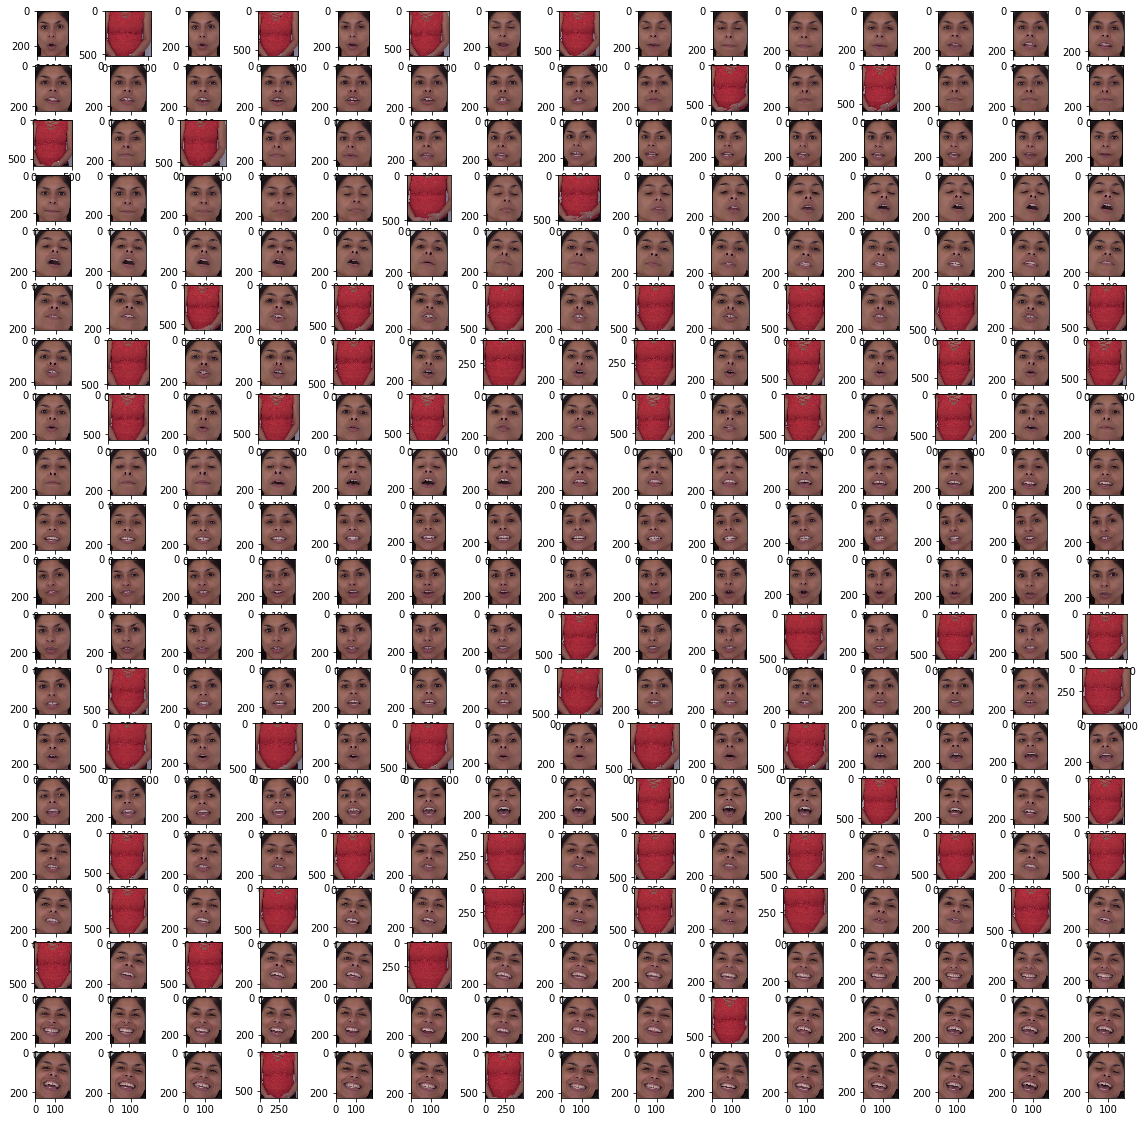

In [18]:
show_faces(all_faces1, 20, 15)

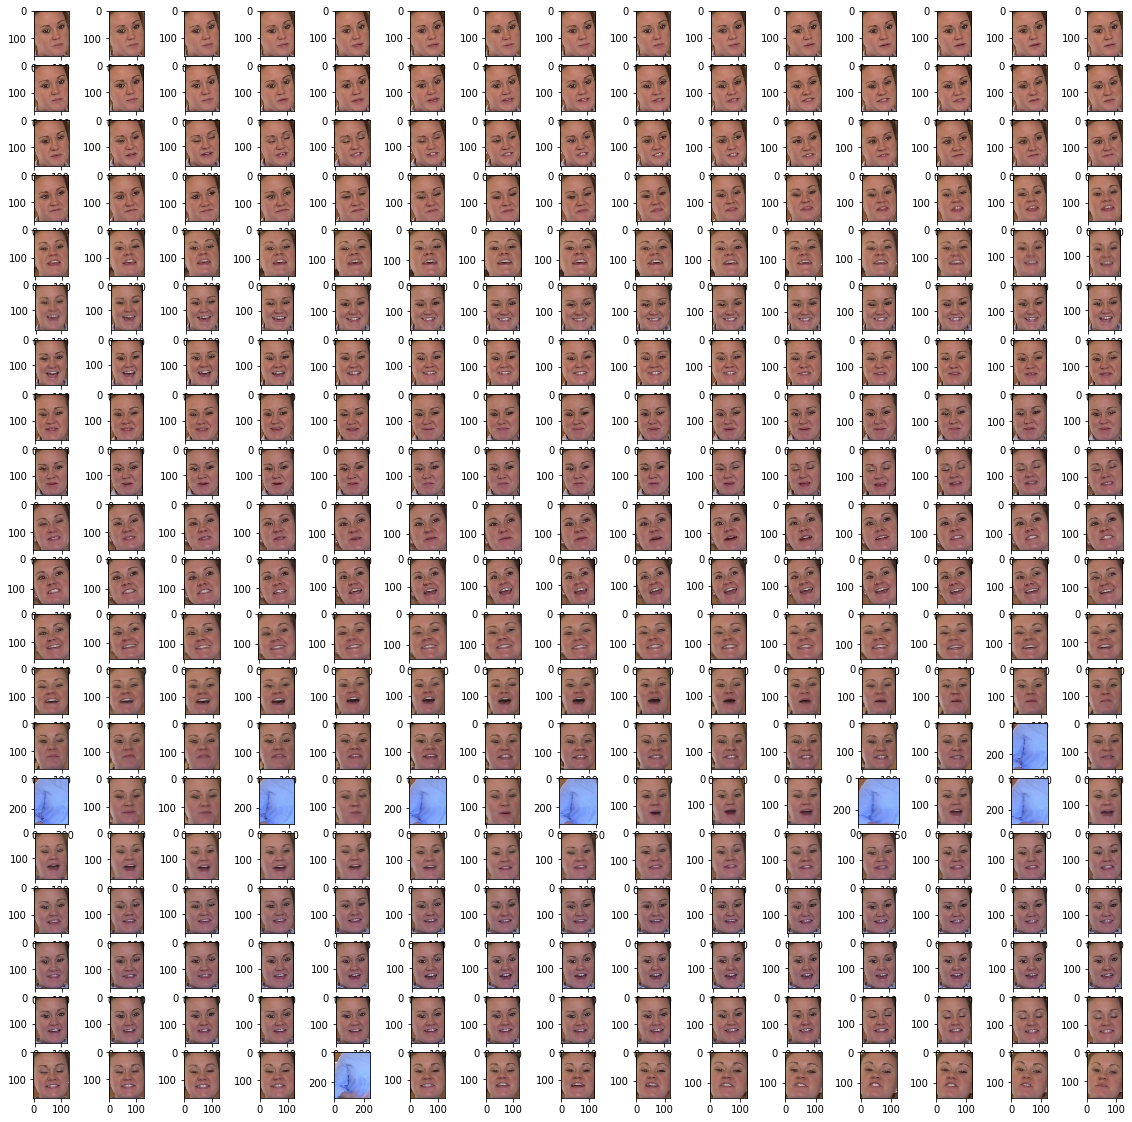

In [19]:
show_faces(all_faces2, 20, 15)

Some takeaways:

- This method is marginally faster than MTCNN (about 11 images/sec) but slower than BlazeFace
- This method consistently makes mistakes even on easy images
- This method generates many warnings from PyTorch and was a little annoying to use

In general I recommend that we don't make use of this approach.